In [128]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import nussl
from utils import viz, data
import yaml
import os

In [129]:
from models.MaskInference import MaskInference
from models.UNet import UNetSpect
nussl.ml.register_module(MaskInference)
nussl.ml.register_module(UNetSpect)

In [130]:
os.listdir('models/')

['.ipynb_checkpoints',
 'ST_mask_10_256_32hop',
 'ST_mask_10_256_0.3dropout',
 '__pycache__',
 'ST_mask_5layer_256hidden',
 'MaskInference.py',
 'ST_mask_0.01LR_5layer',
 'ST_mask_10_256_1e-4LR',
 'Waveform.py',
 'UNet.py',
 'Filterbank.py',
 'ST_mask_1layer',
 'ST_mask_5layer',
 'Clustering.py',
 'ST_unet_16f',
 'ST_mask_10layer_256hidden',
 'ST_mask_10layer2']

In [131]:
model_name = 'ST_unet_16f'

In [132]:
model_path = 'models/'+model_name+'/checkpoints/latest.model.pth'
config_path = 'models/'+model_name+'/configs.yml'

#Optimizer checkpoints no longer stored
#optimizer_path = 'models/'+model_name+'/checkpoints/latest.optimizer.pth'

In [133]:
#Load yaml configs into configs dictionary
with open(config_path,'r') as f:
    configs = yaml.safe_load(f)
    f.close()
stft_params = nussl.STFTParams(**configs['stft_params'])

In [134]:
model_checkpoint = torch.load(model_path,map_location=torch.device('cpu'))

#Optimizer checkpoints no longer stored
#optimizer_checkpoint = torch.load(optimizer_path,map_location=torch.device('cpu'))

In [135]:
model_checkpoint['metadata']['trainer.state_dict']

{'epoch': 25,
 'epoch_length': 25,
 'max_epochs': 25,
 'output': {'loss_L1': 0.00014014009502716362, 'loss': 0.00014014009502716362},
 'metrics': {'avg_loss': 0.0001856098551519343},
 'seed': None}

In [136]:
val_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['validation/loss']
train_loss = model_checkpoint['metadata']['trainer.state.epoch_history']['train/loss']
n_epochs = model_checkpoint['metadata']['trainer.state_dict']['epoch']

Text(0.5, 0, 'Epoch')

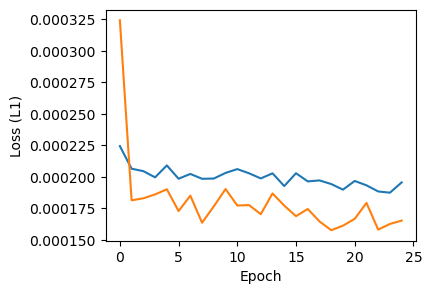

In [137]:
x = np.arange(n_epochs)
plt.figure(figsize=(4,3))
plt.plot(x,val_loss)
plt.plot(x,train_loss)
plt.ylabel('Loss (L1)')
plt.xlabel('Epoch')

/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/separation/base/separation_base.py:73: UserWarning: input_audio_signal has no data!
  warnings.warn('input_audio_signal has no data!')
/SFS/user/ry/stonekev/miniconda3/envs/audio/lib/python3.10/site-packages/nussl/core/audio_signal.py:455: UserWarning: Initializing STFT with data that is non-complex. This might lead to weird results!
  warnings.warn('Initializing STFT with data that is non-complex. '


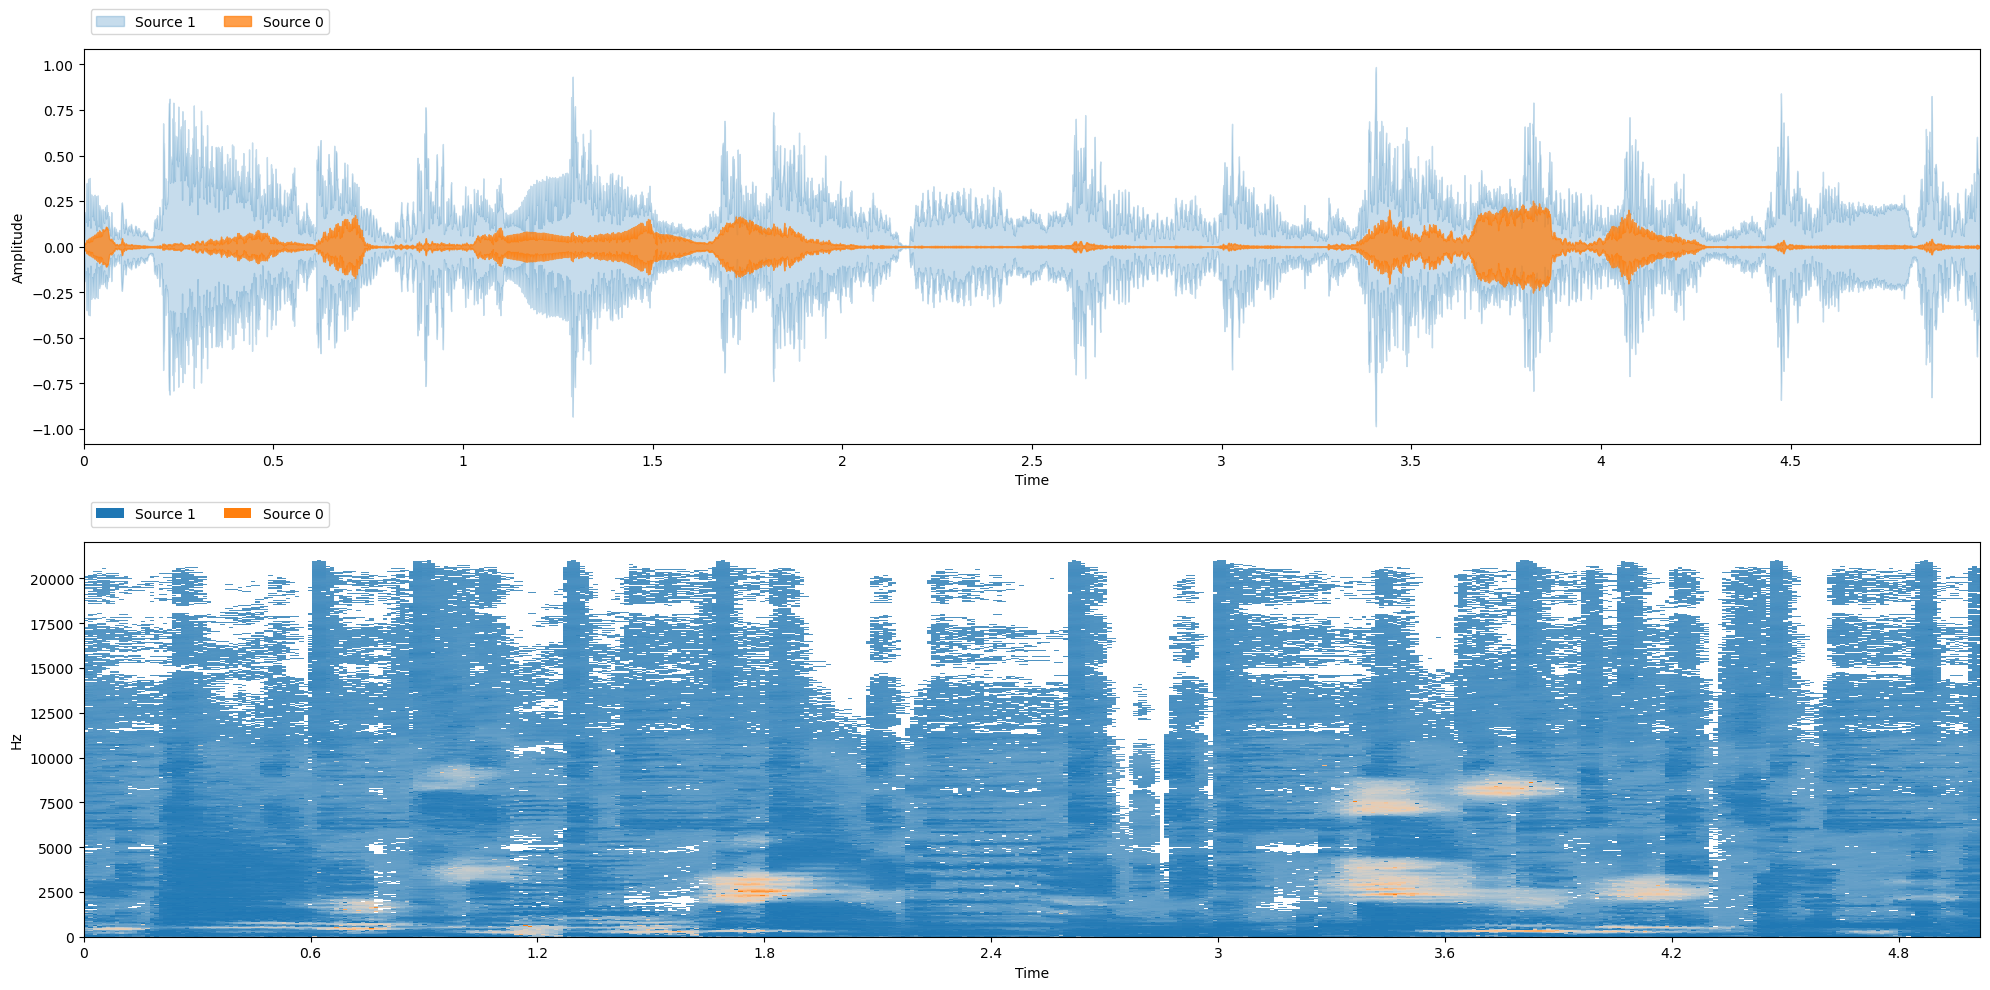


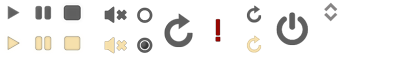
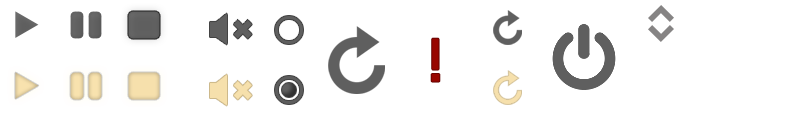
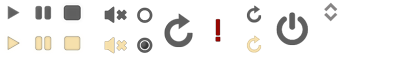

In [122]:
#Load in the model
separator = nussl.separation.deep.DeepMaskEstimation(
    nussl.AudioSignal(), model_path=model_path,
    device='cpu',
)


#Test on the data
test_folder = configs['test_folder']
test_data = data.mixer(stft_params, transform=None, fg_path=configs['test_folder'], num_mixtures=999999, coherent_prob=1.0, duration=5)
item = test_data[1]
separator.audio_signal = item['mix']
estimates = separator()
estimates.append(item['mix'] - estimates[0])

viz.show_sources(estimates)

In [127]:
signal1 = item['mix']

print("Duration: {} seconds".format(signal1.signal_duration))
print("Duration in samples: {} samples".format(signal1.signal_length))
print("Number of channels: {} channels".format(signal1.num_channels))
print("File name: {}".format(signal1.file_name))
print("Full path to input: {}".format(signal1.path_to_input_file))
print("Root mean square energy: {:.4f}".format(signal1.rms().mean()))

Duration: 5.0 seconds
Duration in samples: 220500 samples
Number of channels: 1 channels
File name: None
Full path to input: None
Root mean square energy: 0.1634


In [111]:
# import json
# from nussl.datasets import transforms as nussl_tfm
# from pathlib import Path

# tfm = nussl_tfm.Compose([
#     nussl_tfm.SumSources([['bass', 'drums', 'other']]),
# ])
# test_dataset = nussl.datasets.MUSDB18(subsets=['test'], transform=tfm)

# # Just do 5 items for speed. Change to 50 for actual experiment.
# for i in range(5):
#     item = test_dataset[i]
#     separator.audio_signal = item['mix']
#     estimates = separator()

#     source_keys = list(item['sources'].keys())
#     estimates = {
#         'vocals': estimates[0],
#         'bass+drums+other': item['mix'] - estimates[0]
#     }

#     sources = [item['sources'][k] for k in source_keys]
#     estimates = [estimates[k] for k in source_keys]

#     evaluator = nussl.evaluation.BSSEvalScale(
#         sources, estimates, source_labels=source_keys
#     )
#     scores = evaluator.evaluate()

In [58]:
# scores